In [5]:
import numpy as np
import matplotlib.pyplot as plt

import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet, Constraint
from pyomo.dae import *

import jax
import jax.numpy as jnp

### Pyomo -> ipopt 

## `1`. Testing Pyomo

#### Generate Synthetic Data + Noise

In [6]:
def chebyshev_nodes_second_kind(n, stop=1, start=-1):
    k = np.arange(n)
    x = np.cos(np.pi * k / (n - 1))
    nodes = 0.5 * (stop - start) * x + 0.5 * (start + stop)
    return np.sort(nodes)

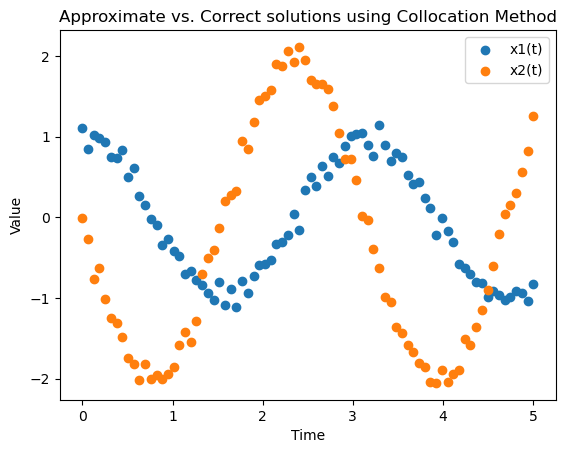

In [7]:
omega = 2.0  # Frequency of the harmonic oscillator
T = 5.0
N = 80
t_grid = np.linspace(0, T, N)

# True solution (for synthetic data generation purposes)
true_u = np.cos(omega * t_grid)
true_v = -omega * np.sin(omega * t_grid)

# Add some noise to simulate real-world data
data_u = true_u + 0.1 * np.random.randn(N)
data_v = true_v + 0.1 * np.random.randn(N)

plt.scatter(t_grid, data_u, label='x1(t)')
plt.scatter(t_grid, data_v, label='x2(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Approximate vs. Correct solutions using Collocation Method')
plt.show()

### Pyomo Model

* `Pyomo` is a collection of Python software packages for formulating optimization models
* Supports multiple solvers, including:
* `IPOPT`, short for "Interior Point OPTimizer, pronounced I-P-Opt", is a software library for large scale nonlinear optimization of continuous systems.

In [8]:
#---------------------------MODEL DEFINITION----------------------------#
model = ConcreteModel()

# Define the indexed set for the time grid 
"""
Create an indexed set named t_idx that contains integers from 0 to N-1. 
This set will be used to index other components in the Pyomo model, such as variables and constraints
"""
model.t_idx = RangeSet(0, N-1)

#---------------------------VARIABLE DEFINITION--------------------------#
model.u = Var(model.t_idx)
model.v = Var(model.t_idx)

#---------------------------INITIAL CONDITIONS---------------------------#
model.u[0].fix(1.0)
model.v[0].fix(0.0)

#-----------------------------ODE CONSTRAINTS----------------------------#
def _ode_u(m, i):
    """
    m : Pyomo model
    i : time index
    """
    if i == 0:
        # skip the first time point since 
        # we have already defined the initial conditions
        return Constraint.Skip
        
    # finite difference approximation of the first derivative
    dt = t_grid[i] - t_grid[i-1]
    
    # approximates the derivative of 
    # u with respect to time using a backward finite difference method
    result = (m.u[i] - m.u[i-1]) / dt == m.v[i-1]
    return result

def _ode_v(m, i):
    if i == 0:
        return Constraint.Skip
    dt = t_grid[i] - t_grid[i-1]
    
    result = (m.v[i] - m.v[i-1]) / dt == -omega**2 * m.u[i-1]
    return result

# add the constraints to the model
model.ode_u = Constraint(model.t_idx, rule=_ode_u)
model.ode_v = Constraint(model.t_idx, rule=_ode_v)


#---------------------------OBJECTIVE FUNCTION---------------------------#
def _objective(m):
    return sum((m.u[i] - data_u[i])**2 + (m.v[i] - data_v[i])**2 for i in m.t_idx)

model.obj = Objective(rule=_objective, sense=1) 

#---------------------------SOLVING THE MODEL----------------------------#
# using IPOPT
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      158

Total number of variables............................:      158
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      158
Total number

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 158, 'Number of variables': 158, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.16\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.01886272430419922}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [9]:
#------------------------------EXTRACT-------------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
v_solution = np.array([value(model.v[i]) for i in model.t_idx])

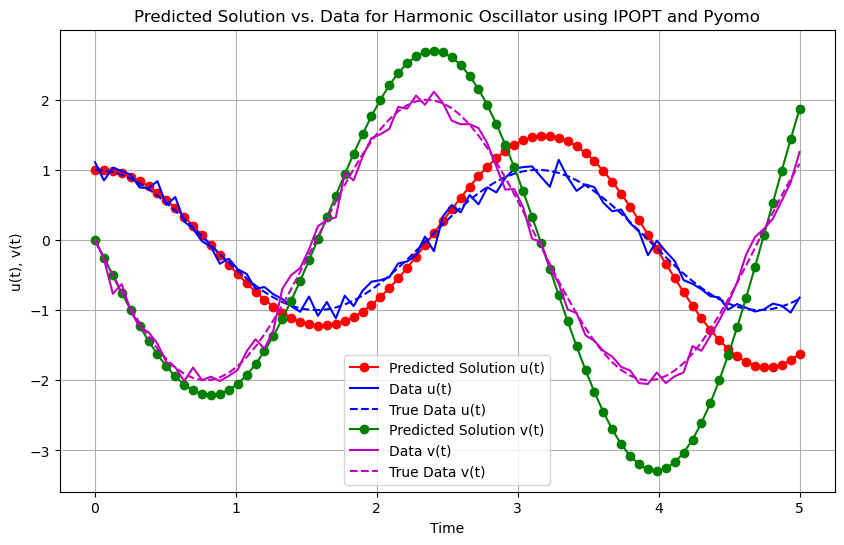

In [10]:
#-------------------------------PLOT---------------------------------#
plt.figure(figsize=(10, 6))
plt.plot(t_grid, u_solution, 'ro-', label='Predicted Solution u(t)')
plt.plot(t_grid, data_u, 'b-', label='Data u(t)')
plt.plot(t_grid, true_u, 'b--', label='True Data u(t)')
plt.plot(t_grid, v_solution, 'go-', label='Predicted Solution v(t)')
plt.plot(t_grid, data_v, 'm-', label='Data v(t)')
plt.plot(t_grid, true_v, 'm--', label='True Data v(t)')
plt.xlabel('Time')
plt.ylabel('u(t), v(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Harmonic Oscillator using IPOPT and Pyomo')
plt.grid(True)
plt.show()


## `2`. Extending to use a collocation matrix

In [11]:
def lagrange_basis(j, x, nodes):
    """Evaluate the j-th Lagrange basis polynomial at x."""
    terms = [(x - nodes[m]) / (nodes[j] - nodes[m]) for m in range(len(nodes)) if m != j]
    return np.prod(terms)

def lagrange_basis_derivative(j, x, nodes):
    """Evaluate the derivative of the j-th Lagrange basis polynomial at x."""
    terms = []
    for m in range(len(nodes)):
        if m != j:
            product_terms = [(x - nodes[n]) / (nodes[j] - nodes[n]) for n in range(len(nodes)) if n != j and n != m]
            terms.append(np.prod(product_terms) / (nodes[j] - nodes[m]))
    return np.sum(terms)

def collocation_matrix(nodes):
    """Construct the collocation matrix for the given nodes."""
    N = len(nodes)
    matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            matrix[i, j] = lagrange_basis_derivative(j, nodes[i], nodes)
    return matrix

In [25]:
import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'collocation2'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation_improved import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation

### du_dt = -u

In [46]:
#---------------------------DATA GENERATION--------------------------#
T = 5.0
N = 10

interpolant = BarycentricInterpolation(N, 0, T)
t_grid = np.array(interpolant.nodes)
# t_grid = np.linspace(0, T, N)

# True solution (for synthetic data generation purposes)
true_u = np.exp(-t_grid)

# Add some noise to simulate real-world data
data_u = true_u + 0.1 * np.random.randn(N)

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t_grid)
D = lagrange_derivative(t_grid, weights)
D = np.array(D)

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()

model.t_idx = RangeSet(0, N-1)

#---------------------------VARIABLE DEFINITION--------------------------#
model.u = Var(model.t_idx)

#---------------------------INITIAL CONDITIONS---------------------------#
model.initial_conditions = ConstraintList()
model.initial_conditions.add(model.u[0] == 1.0)

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
model.ode_u = ConstraintList()

# for each time point, add the ODE constraint
for i in range(1, N):
    du_dt = sum(D[i, j] * model.u[j] for j in range(N))
    model.ode_u.add(du_dt == -model.u[i])

#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    return sum((m.u[i] - data_u[i])**2 for i in m.t_idx)

model.obj = Objective(rule=_objective, sense=pyo.minimize)

#---------------------------INITIAL GUESSES--------------------------#
'''for i in model.t_idx:
    model.u[i] = np.exp(-t_grid[i])  # Initialize with an exponential decay'''
    
#---------------------------SOLVING THE MODEL--------------------------#
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])

# Print the results
print("u(t):", u_solution)


Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:       91
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       10
Total number

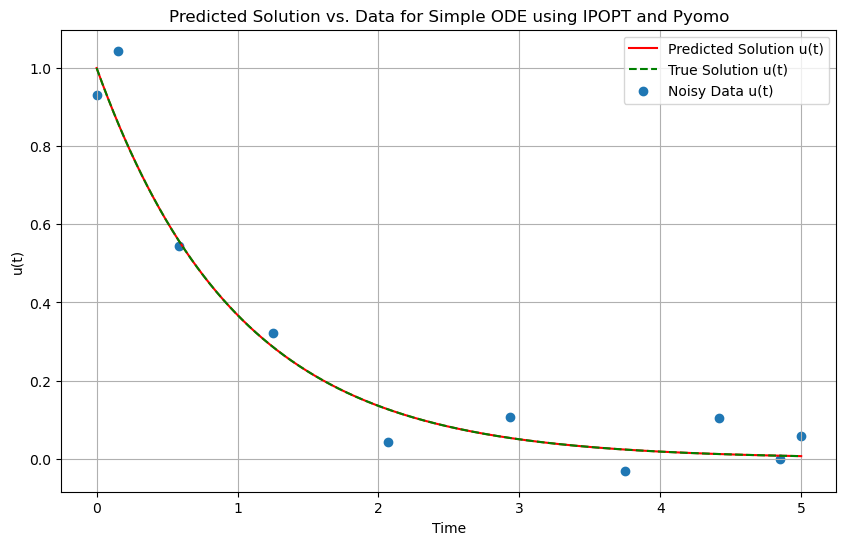

In [47]:
t = np.linspace(0, T, 1000)

interpolant.fit(u_solution)
u_solution_ = interpolant.evaluate(t)
true_u = np.exp(-t)

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 6))
# plt.scatter(t_grid, u_solution, label='Predicted Solution u(t)')
# plt.scatter(t_grid, data_u, label='Data u(t)')
plt.plot(t, u_solution_, 'r', label='Predicted Solution u(t)')
plt.plot(t, true_u, 'g--', label='True Solution u(t)')
plt.scatter(t_grid, data_u, label='Noisy Data u(t)')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple ODE using IPOPT and Pyomo')
plt.grid(True)
plt.show()

## Harmonic Oscillator

$
\begin{cases}
\frac{dx_1}{dt} = x_2 \\
\frac{dx_2}{dt} = -\omega^2 x_1
\end{cases}
$

$
\begin{cases}
\frac{du}{dt} = v \\
\frac{dv}{dt} = -\omega^2 u
\end{cases}
$

In [55]:
#---------------------------DATA GENERATION--------------------------#
omega = 1.0  # Frequency of the harmonic oscillator
T = 10.0
N = 100
interpolant = BarycentricInterpolation(N, 0, T)
t_grid = np.array(interpolant.nodes)

# True solution (for synthetic data generation purposes)
true_u = np.cos(omega * t_grid)
true_v = -omega * np.sin(omega * t_grid)

# Add some noise to simulate real-world data
data_u = true_u + 0.05 * np.random.randn(N)
data_v = true_v + 0.05 * np.random.randn(N)

#---------------------------COLLOCATION MATRIX--------------------------#
phi = np.eye(N)
weights = compute_weights(t_grid)
D = lagrange_derivative(t_grid, weights)
D = np.array(D)

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()

model.t_idx = RangeSet(0, N-1)

#---------------------------VARIABLE DEFINITION--------------------------#
model.u = Var(model.t_idx)
model.v = Var(model.t_idx)

#---------------------------INITIAL CONDITIONS---------------------------#
model.initial_conditions = ConstraintList()
model.initial_conditions.add(model.u[0] == 1.0)
model.initial_conditions.add(model.v[0] == 0.0)

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
model.ode_u = ConstraintList()
model.ode_v = ConstraintList()

for i in range(1, N):
    du_dt = sum(D[i, j] * model.u[j] for j in range(N))
    dv_dt = sum(D[i, j] * model.v[j] for j in range(N))
    model.ode_u.add(du_dt == model.v[i])
    model.ode_v.add(dv_dt == -omega**2 * model.u[i])

#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    return sum((m.u[i] - data_u[i])**2 + (m.v[i] - data_v[i])**2 for i in m.t_idx)

model.obj = Objective(rule=_objective, sense=pyo.minimize)

#---------------------------SOLVING THE MODEL--------------------------#
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
v_solution = np.array([value(model.v[i]) for i in model.t_idx])

# Print the results
# print("u(t):", u_solution)
# print("v(t):", v_solution)


Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    20000
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number

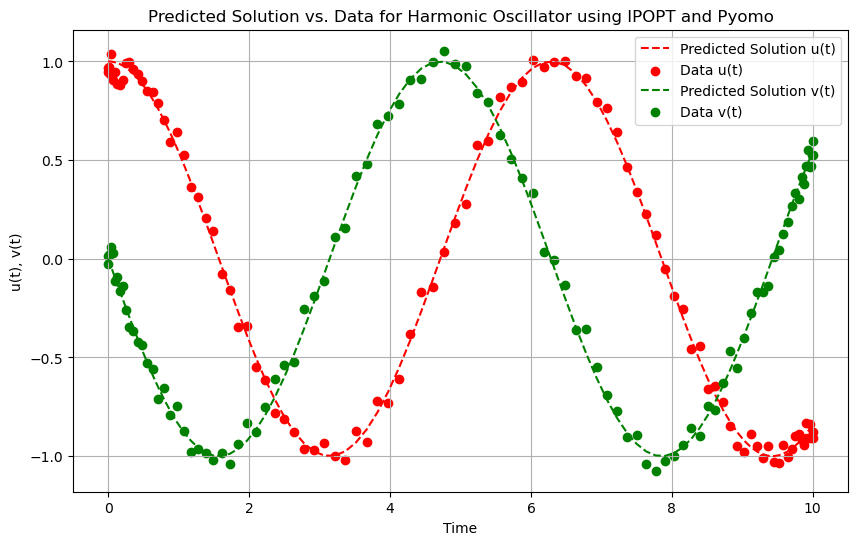

In [58]:
t = np.linspace(0, T, 1000)

interpolant.fit(u_solution)
u_solution_ = interpolant.evaluate(t)

interpolant.fit(v_solution)
v_solution_ = interpolant.evaluate(t)

u_0, v_0 = 1.0, 0.0
u_correct = u_0 * jnp.cos(omega * t ) + (v_0 / omega) * jnp.sin(omega * t )
v_correct = v_0 * jnp.cos(omega * t ) - u_0 * omega * jnp.sin(omega * t )

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 6))
plt.plot(t_grid, u_solution, 'r--', label='Predicted Solution u(t)')
plt.scatter(t_grid, data_u, label='Data u(t)', color='r')
plt.plot(t_grid, v_solution, 'g--', label='Predicted Solution v(t)')
plt.scatter(t_grid, data_v, label='Data v(t)', color='g')
plt.xlabel('Time')
plt.ylabel('u(t), v(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Harmonic Oscillator using IPOPT and Pyomo')
plt.grid(True)
plt.show()